In [36]:
# Imports using Sklearn make shortcut functions
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.inspection import permutation_importance

from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Imports
import os
from google.cloud import bigquery

In [37]:
data = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/1988_to_2024_combined_clean_polling_and_results.csv')

In [38]:
# # Environment variables
# gcp_project_id = os.environ['GCP_PROJECT']
# gcp_service_account_key = os.environ['GCP_SERVICE_ACCOUNT_KEY']
# bq_source_dataset = os.environ['BQ_SOURCE_DATASET']
# bq_cleaned_dataset = os.environ['BQ_CLEANED_DATASET']

In [39]:
# # Environment variables
# gcp_project_id = os.environ['GCP_PROJECT']
# gcp_service_account_key = os.environ['GCP_SERVICE_ACCOUNT_KEY']

# # Import data from BQ and set data to X
# # Initialize a BigQuery client using the service account JSON file
# bq_client = bigquery.Client(project=gcp_project_id).from_service_account_json(gcp_service_account_key)

# # SQL query
# query = f"""
#     SELECT *
#     FROM `{gcp_project_id}.master_sources.national_polls_results_combined`
#     """
# # Use BQ client to create DF from the selected table
# data = bq_client.query(query).to_dataframe()


In [40]:
# data.rename(columns={'int64_field_0':'startdate'},inplace=True)

In [41]:
# # Import data from BQ and set data to X
# # Initialize a BigQuery client using the service account JSON file
# bq_client = bigquery.Client(project=gcp_project_id).from_service_account_json(gcp_service_account_key)

# # Setting the table we want from the source dataset
# select_table = 'cleaned_full_polls_combined_national_results_2004_2019'

# # SQL query for querying Big Query and fetching entire table
# query = f"""
#     SELECT *
#     FROM `{gcp_project_id}.{bq_cleaned_dataset}.{select_table}`
# """

In [42]:
# # Use BQ client to create DF from the selected table
# data = bq_client.query(query).to_dataframe()

In [43]:
# # Replace any found NaN values with 0
# data.replace(np.nan, 0, inplace=True)

# # Add a field 'poll length' that shows number of days the poll was held for
# data['poll_length'] = pd.to_datetime(data.enddate) - pd.to_datetime(data.startdate)
# data['poll_length'] = data['poll_length'].dt.days

# # Divide forecasts by 100 to create values between 0-1
# # for column in ['BRX_FC', 'CON_FC', 'GRE_FC', 'LAB_FC', 'LIB_FC', 'OTH_FC', 'PLC_FC', 'SNP_FC', 'UKI_FC']:
# #     data[column] = data[column] / 100

# #     # Divide actuals by 100 to create values between 0-1
# # for column in ['BRX_ACT', 'CON_ACT', 'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT', 'OTH_PERCENTAGE']:
# #     data[column] = data[column] / 100

# data.sort_values('enddate', inplace=True)

# data.reset_index(inplace=True)

In [44]:
# Load Trends csvs from raw_data folder
trends1 = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/LAB_CON_LIB_GRE_BRX_Trends_2004_now.csv')
trends2 = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/LAB_PLC_SNP_UKI_NAT_Trends_2004_now.csv')

In [45]:
# Drop duplicate Labour column
trends2.drop(columns='Labour Party: (United Kingdom)',inplace=True)

In [46]:
# Join two trends datasets on 'Month'
trends_merged = pd.merge(trends1,trends2,how='left',on='Month')

In [47]:
trends_merged['Month'] = pd.to_datetime(trends_merged['Month'])

In [48]:
# Replace <1 values with 0.5 value
trends_merged.replace('<1', 0.5,inplace=True)

In [49]:
# Converting objects (pd.Series) to int dtypes
trends_merged = trends_merged.astype({'Green Party: (United Kingdom)':'int','Reform UK: (United Kingdom)':'int',\
    'Plaid Cymru: (United Kingdom)':'int','Scottish National Party: (United Kingdom)':'int',\
        'UK Independence Party: (United Kingdom)':'int','British National Party: (United Kingdom)':'int'})

In [50]:
# Rename columns to align them more easily with _FC and _ACT columns
trends_merged.rename(columns={'Labour Party: (United Kingdom)': 'LAB_trends',
        'Conservative Party: (United Kingdom)': 'CON_trends',
        'Liberal Democrats: (United Kingdom)': 'LIB_trends',
        'Green Party: (United Kingdom)': 'GRE_trends',
        'Reform UK: (United Kingdom)': 'BRX_trends',
        'Plaid Cymru: (United Kingdom)': 'PLC_trends',
        'Scottish National Party: (United Kingdom)': 'SNP_trends',
        'UK Independence Party: (United Kingdom)': 'UKI_trends',
        'British National Party: (United Kingdom)': 'NAT_trends'}
        ,inplace=True)

In [51]:
# trends_merged.to_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/national_google_trends_master.csv')

In [52]:
# Loading ONS csv files
ons_gdp = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_gdp_2004_2024.csv')
ons_inf = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_inflation_2004_2024.csv')
ons_emp = pd.read_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_unemployment_2004_2024.csv')

In [53]:
# Replacing spaces with - for GDP df
ons_gdp.Quarter = ons_gdp.Quarter.str.replace(' ', '-')

# Turning quarters into months for GDP df
ons_gdp.Quarter = pd.PeriodIndex(ons_gdp.Quarter, freq='Q').to_timestamp()

# Fill missing months and impute with quarterly values per month for GDP df
ons_gdp = ons_gdp.set_index('Quarter').resample('MS').ffill()
ons_gdp.index.names = ['Month']

In [54]:
# Convert months into pd.DateTime and set as index
ons_inf.Month = pd.to_datetime(ons_inf.Month)
ons_inf = ons_inf.set_index('Month')

ons_emp.Month = pd.to_datetime(ons_emp.Month)
ons_emp = ons_emp.set_index('Month')

/var/folders/kb/jn3km5pj6lnd7dfkgljcjy300000gn/T/ipykernel_23352/3454880804.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ons_inf.Month = pd.to_datetime(ons_inf.Month)
/var/folders/kb/jn3km5pj6lnd7dfkgljcjy300000gn/T/ipykernel_23352/3454880804.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ons_emp.Month = pd.to_datetime(ons_emp.Month)


In [55]:
# Merging GDP, Inflation and Unemployment dfs into ons_merged
ons_merged = pd.merge(ons_gdp,pd.merge(ons_inf,ons_emp,how='left',on='Month'),how='outer',on='Month')

# Filling NaNs with previous value of column
ons_merged = ons_merged.ffill()

In [56]:
# ons_merged.to_csv('/Users/nieksonneveld/code/nieksonneveld/election-predictor/raw_data/ons_economic_data_master.csv')

In [57]:
ons_merged.head()

,GDP,Inflation,Unemployment
Month,,,
2004-01-01,322790.0,1.5,4.8
2004-02-01,322790.0,1.4,4.8
2004-03-01,322790.0,1.2,4.8
2004-04-01,329664.0,1.1,4.8
2004-05-01,329664.0,1.4,4.8


In [58]:
# Create poll enddate field with YYYY-MM format, so we can join with Trends data
data['enddate_year_month'] = pd.to_datetime(data['enddate']).dt.to_period('M')

In [59]:
# Convert Period datatype to str and then to datetime64
data.enddate_year_month = pd.to_datetime(data.enddate_year_month.astype('str'))

In [60]:
# Merge data with trends data, to get a df with polls, election results and trends
data_trends = pd.merge(data,trends_merged,how='left',left_on='enddate_year_month',right_on='Month')

In [61]:
# Merge data with ONS data, to get a df with polls, election results, trends and ONS data
data_trends_ons = pd.merge(data_trends,ons_merged,how='left',left_on='enddate_year_month',right_on='Month')

In [62]:
# Scale trends columns by diving by 100
for column in ['LAB_trends', 'CON_trends', 'LIB_trends',
       'GRE_trends', 'BRX_trends', 'PLC_trends', 'SNP_trends', 'UKI_trends',
       'NAT_trends']:
    data_trends_ons[column] = data_trends_ons[column] / 100

In [63]:
# Drop columns we don't need
data_trends_ons = data_trends_ons.drop(columns=['startdate', 'enddate', 'pollster'])

In [64]:
data_trends_ons.columns

Index(['Unnamed: 0', 'samplesize', 'rating', 'next_elec_date', 'days_to_elec',
       'months_to_elec', 'months_to_elec_weight', 'poll_length',
       'party_in_power', 'CON_FC', 'LAB_FC', 'LIB_FC', 'BRX_FC', 'GRE_FC',
       'OTH_FC', 'PLC_FC', 'SNP_FC', 'UKI_FC', 'CON_ACT', 'LAB_ACT', 'LIB_ACT',
       'BRX_ACT', 'GRE_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT', 'OTH_PERCENTAGE',
       'enddate_year_month', 'Month', 'LAB_trends', 'CON_trends', 'LIB_trends',
       'GRE_trends', 'BRX_trends', 'PLC_trends', 'SNP_trends', 'UKI_trends',
       'NAT_trends', 'GDP', 'Inflation', 'Unemployment'],
      dtype='object')

In [65]:
from datetime import datetime
# Split data up to 2017 election (TRAIN) and all data related to 2019 election (TEST)
data_trends_ons['next_elec_date'] = data_trends_ons['next_elec_date'].astype("datetime64[ns]")
data_train = data_trends_ons[data_trends_ons['next_elec_date'] < datetime.strptime('2015-05-07', '%Y-%m-%d')]
data_train = data_train[data_train['next_elec_date'] >= datetime.strptime('2005-05-05', '%Y-%m-%d')]
data_test = data_trends_ons[data_trends_ons['next_elec_date'] == datetime.strptime('2015-05-07', '%Y-%m-%d')]

In [73]:
data_train.party_in_power.value_counts()

party_in_power
Labour    682
Name: count, dtype: int64

In [67]:
# Handle numerical transformer
num_columns_selector = ['samplesize', 'days_to_elec', 'poll_length','GDP','Inflation','Unemployment','months_to_elec','months_to_elec_weight']
num_transformer = MinMaxScaler()

In [74]:
# Handle categorical transformer
cat_columns_selector = ['rating']
cat_transformer = make_pipeline(OrdinalEncoder(categories = [['F','F+','E-','E','E+','D-','D','D+','C-','C','C+','B-','B','B+','A-']]),MinMaxScaler())

# One-hot encoder for party_in_power
ohe = OneHotEncoder(handle_unknown='ignore')

In [75]:
# Build the preprocessing pipeline
preproc_pipeline = make_column_transformer(
    (num_transformer, num_columns_selector),
    (cat_transformer, cat_columns_selector),
    (ohe,['party_in_power']),
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [76]:
# Fit transform preprocessing pipeline to data_train
data_train_processed = preproc_pipeline.fit_transform(data_train)

# Transform preprocessing pipeline to data_test
data_test_processed = preproc_pipeline.transform(data_test)

In [77]:
# Check feature names make sense for data_train
data_train_processed = pd.DataFrame(
    data_train_processed, columns=preproc_pipeline.get_feature_names_out()
)

# Check feature names make sense for data_test
data_test_processed = pd.DataFrame(
    data_test_processed, columns=preproc_pipeline.get_feature_names_out()
)

In [78]:
# # Define our X by dropping irrelevant and y columns

# X_train = data_train_processed.drop(columns=['index','days_to_elec','next_elec_date', 'BRX_ACT', 'CON_ACT',
#        'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
#        'OTH_PERCENTAGE','enddate_year_month','Month'])

# X_test = data_test_processed.drop(columns=['index','days_to_elec','next_elec_date', 'BRX_ACT', 'CON_ACT',
#        'GRE_ACT', 'LIB_ACT', 'LAB_ACT', 'PLC_ACT', 'SNP_ACT', 'UKI_ACT',
#        'OTH_PERCENTAGE','enddate_year_month','Month'])

In [160]:
X_train_LAB = data_train_processed[['LAB_FC','months_to_elec_weight']]
X_train_CON = data_train_processed[['CON_FC','months_to_elec_weight']]
X_train_LIB = data_train_processed[['LIB_FC','months_to_elec_weight']]
X_train_GRE = data_train_processed[['GRE_FC','months_to_elec_weight']]
X_train_BRX = data_train_processed[['BRX_FC','months_to_elec_weight']]
X_train_SNP = data_train_processed[['SNP_FC','months_to_elec_weight']]
X_train_UKI = data_train_processed[['UKI_FC','months_to_elec_weight']]
X_train_PLC = data_train_processed[['PLC_FC','months_to_elec_weight']]
X_train_OTH = data_train_processed[['OTH_FC','months_to_elec_weight']]

X_test_LAB = data_test_processed[['LAB_FC','months_to_elec_weight']]
X_test_CON = data_test_processed[['CON_FC','months_to_elec_weight']]
X_test_LIB = data_test_processed[['LIB_FC','months_to_elec_weight']]
X_test_GRE = data_test_processed[['GRE_FC','months_to_elec_weight']]
X_test_BRX = data_test_processed[['BRX_FC','months_to_elec_weight']]
X_test_SNP = data_test_processed[['SNP_FC','months_to_elec_weight']]
X_test_UKI = data_test_processed[['UKI_FC','months_to_elec_weight']]
X_test_PLC = data_test_processed[['PLC_FC','months_to_elec_weight']]
X_test_OTH = data_test_processed[['OTH_FC','months_to_elec_weight']]

In [161]:
# Build our target matrix, retaining each party share vote columns only
y_train = data_train_processed[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
                    'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']]

# Build our target matrix, retaining each party share vote columns only
y_test = data_test_processed[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
                    'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']]

In [162]:
# #TODO – refactor the below into a function > model instantiation, fitting, scoring, etc.
# # Handle target extraction for test and train sets respectively
# #TODO Kwarg > defaults to either cross val or prediction
y_train_LAB = y_train['LAB_ACT']
y_train_CON = y_train['CON_ACT']
y_train_LIB = y_train['LIB_ACT']
y_train_GRE = y_train['GRE_ACT']
y_train_BRX = y_train['BRX_ACT']
y_train_SNP = y_train['SNP_ACT']
y_train_UKI = y_train['UKI_ACT']
y_train_PLC = y_train['PLC_ACT']
y_train_OTH = y_train['OTH_PERCENTAGE']

y_test_LAB = y_test['LAB_ACT']
y_test_CON = y_test['CON_ACT']
y_test_LIB = y_test['LIB_ACT']
y_test_GRE = y_test['GRE_ACT']
y_test_BRX = y_test['BRX_ACT']
y_test_SNP = y_test['SNP_ACT']
y_test_UKI = y_test['UKI_ACT']
y_test_PLC = y_test['PLC_ACT']
y_test_OTH = y_test['OTH_PERCENTAGE']

In [163]:
# # Instantiate the model for each party
model_LAB = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_CON = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_LIB = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_GRE = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_BRX = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_SNP = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_UKI = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_PLC = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)
model_OTH = XGBRegressor(learning_rate=0.3, n_estimators=300,
                                     max_depth=3, subsample=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     #booster='gblinear',
                                     enable_categorical=True)

In [164]:
# # Handle model training
# X_train_matrix = np.array(X_train)

model_LAB.fit(np.array(X_train_LAB), y_train_LAB)
model_CON.fit(np.array(X_train_CON), y_train_CON)
model_LIB.fit(np.array(X_train_LIB), y_train_LIB)
model_GRE.fit(np.array(X_train_GRE), y_train_GRE)
model_BRX.fit(np.array(X_train_BRX), y_train_BRX)
model_SNP.fit(np.array(X_train_SNP), y_train_SNP)
model_UKI.fit(np.array(X_train_UKI), y_train_UKI)
model_PLC.fit(np.array(X_train_PLC), y_train_PLC)
model_OTH.fit(np.array(X_train_OTH), y_train_OTH)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None, nthread=-1,
             num_parallel_tree=None, ...)

In [165]:
# # Evaluate model performance with cross validation
# X_test_matrix = np.array(X_test)

y_pred_LAB = model_LAB.predict(np.array(X_test_LAB))
y_pred_CON = model_CON.predict(np.array(X_test_CON))
y_pred_LIB = model_LIB.predict(np.array(X_test_LIB))
y_pred_GRE = model_GRE.predict(np.array(X_test_GRE))
y_pred_BRX = model_BRX.predict(np.array(X_test_BRX))
y_pred_SNP = model_SNP.predict(np.array(X_test_SNP))
y_pred_UKI = model_UKI.predict(np.array(X_test_UKI))
y_pred_PLC = model_PLC.predict(np.array(X_test_PLC))
y_pred_OTH = model_OTH.predict(np.array(X_test_OTH))

In [166]:
print(f"2015 prediction for LAB: {y_pred_LAB.mean()}")
print(f"2015 prediction for CON: {y_pred_CON.mean()}")
print(f"2015 prediction for LIB: {y_pred_LIB.mean()}")
print(f"2015 prediction for GRE: {y_pred_GRE.mean()}")
print(f"2015 prediction for BRX: {y_pred_BRX.mean()}")
print(f"2015 prediction for SNP: {y_pred_SNP.mean()}")
print(f"2015 prediction for UKI: {y_pred_UKI.mean()}")
print(f"2015 prediction for PLC: {y_pred_PLC.mean()}")
print(f"2015 prediction for OTH: {y_pred_OTH.mean()}")

2015 prediction for LAB: 0.3261714577674866
2015 prediction for CON: 0.33832481503486633
2015 prediction for LIB: 0.2302151322364807
2015 prediction for GRE: 0.009016803465783596
2015 prediction for BRX: 0.0
2015 prediction for SNP: 0.01635545678436756
2015 prediction for UKI: 0.02970544621348381
2015 prediction for PLC: 0.005697145592421293
2015 prediction for OTH: 0.0532250739634037


In [167]:
print(f"2015 prediction for LAB: {y_pred_LAB[-30:-1].mean()}")
print(f"2015 prediction for CON: {y_pred_CON[-30:-1].mean()}")
print(f"2015 prediction for LIB: {y_pred_LIB[-30:-1].mean()}")
print(f"2015 prediction for GRE: {y_pred_GRE[-30:-1].mean()}")
print(f"2015 prediction for BRX: {y_pred_BRX[-30:-1].mean()}")
print(f"2015 prediction for SNP: {y_pred_SNP[-30:-1].mean()}")
print(f"2015 prediction for UKI: {y_pred_UKI[-30:-1].mean()}")
print(f"2015 prediction for PLC: {y_pred_PLC[-30:-1].mean()}")
print(f"2015 prediction for OTH: {y_pred_OTH[-30:-1].mean()}")

2015 prediction for LAB: 0.2905944585800171
2015 prediction for CON: 0.3509264886379242
2015 prediction for LIB: 0.22892910242080688
2015 prediction for GRE: 0.009016805328428745
2015 prediction for BRX: 0.0
2015 prediction for SNP: 0.016250403597950935
2015 prediction for UKI: 0.029609007760882378
2015 prediction for PLC: 0.005704404320567846
2015 prediction for OTH: 0.05257439985871315


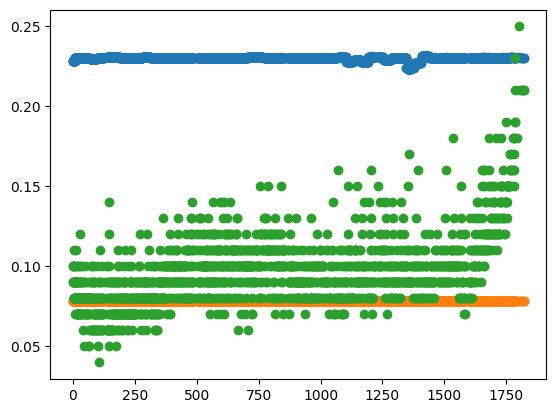

In [170]:
plt.scatter(y=y_pred_LIB,x=data_test['days_to_elec'])
plt.scatter(y=y_test_LIB,x=data_test['days_to_elec'])
plt.scatter(y=data_test['LIB_FC'],x=data_test['days_to_elec'])
plt.scatter(y=data_test['months_to_elec_weight'],x=data_test['days_to_elec']);

### Code below is to test neural network

In [ ]:
# # Converting data to floats for NN
# X_train_matrix_nn = X_train_matrix.astype('float')
# X_test_matrix_nn = X_test_matrix.astype('float')


# y_train_LAB_nn = y_train_LAB.astype('float')

# y_test_LAB_nn = y_test_LAB.astype('float')

In [ ]:
# # Initialising Dense NN model

# def initialize_model():

#     model = models.Sequential()

#     model.add(layers.Dense(20, input_dim=X_train_matrix.shape[1], activation='relu'))  # /!\ Input size is equal to number of features
#     model.add(layers.Dense(10, activation='relu'))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.Dense(10, activation='relu'))
#     model.add(layers.Dense(1, activation='linear')) # /!\ Trying to predict continuous variable (regression task)

#     return model

In [ ]:
# # Compile model using adam optimiser and MSE as loss function

# def compile_model(model, optimizer_name):
#     model.compile(loss='mse', optimizer=optimizer_name, metrics=['mse'])
#     return model

In [ ]:
# model = initialize_model()
# compile_model(model,'adam')
# es = EarlyStopping(patience=5, restore_best_weights=True)

# history = model.fit(X_train_matrix_nn, y_train_LAB_nn,
#           batch_size=16,
#           epochs=1000,
#           callbacks=[es])

# results = model.evaluate(X_test_matrix_nn,y_test_LAB_nn)

In [ ]:
# y_pred_LAB_nn = model.predict(X_test_matrix_nn)

In [ ]:
# print(y_pred_LAB_nn[-1])

#### Investigating features for collinearity and feature permutation

poll_length
16560    9
17323    8
14733    7
18240    7
18144    6
        ..
15243    1
15242    1
15241    1
15239    1
15736    1
Name: count, Length: 2426, dtype: int64

In [ ]:
data_trends_ons[['LAB_ACT', 'CON_ACT', 'LIB_ACT', 'GRE_ACT', 'BRX_ACT',
                    'SNP_ACT', 'UKI_ACT', 'PLC_ACT', 'OTH_PERCENTAGE']].describe()

,LAB_ACT,CON_ACT,LIB_ACT,GRE_ACT,BRX_ACT,SNP_ACT,UKI_ACT,PLC_ACT,OTH_PERCENTAGE
count,3260.000000,3260.000000,3260.000000,3260.000000,3260.000000,3260.000000,3260.000000,3260.000000,3260.000000
mean,0.312252,0.379589,0.112554,0.027979,0.002717,0.038891,0.082386,0.005649,0.037983
std,0.027525,0.027846,0.058790,0.011052,0.006878,0.012097,0.053833,0.000421,0.009334
min,0.289896,0.323596,0.073654,0.008934,0.000000,0.015186,0.000713,0.004788,0.032733
25%,0.304506,0.368110,0.078705,0.015909,0.000000,0.030356,0.030986,0.005571,0.032733
50%,0.304506,0.368110,0.078705,0.036210,0.000000,0.047382,0.126435,0.005919,0.032733
75%,0.304506,0.368110,0.115477,0.036210,0.000000,0.047382,0.126435,0.005919,0.036837
max,0.399893,0.436317,0.230289,0.036210,0.020127,0.047382,0.126435,0.006440,0.057233


In [ ]:
data_test_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   samplesize                   440 non-null    object        
 1   days_to_elec                 440 non-null    object        
 2   poll_length                  440 non-null    object        
 3   GDP                          440 non-null    object        
 4   Inflation                    440 non-null    object        
 5   Unemployment                 440 non-null    object        
 6   months_to_elec_weight        440 non-null    object        
 7   rating                       440 non-null    object        
 8   party_in_power_Conservative  440 non-null    object        
 9   party_in_power_Labour        440 non-null    object        
 10  index                        440 non-null    object        
 11  next_elec_date               440 non-null    

<Axes: >

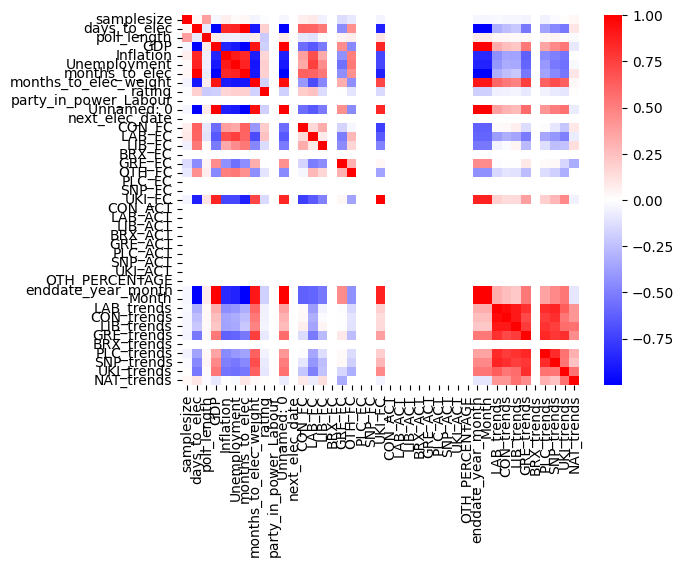

In [145]:
# Heatmap of pairwise correlations
correlation_matrix = data_test_processed.corr()
column_names = correlation_matrix.columns
sns.heatmap(correlation_matrix, xticklabels=column_names, yticklabels=column_names,cmap= "bwr")

In [146]:
# Convert the correlation matrix into a DataFrame
corr_df = correlation_matrix.stack().reset_index()

# Rename the columns
corr_df.columns = ['feature_1','feature_2', 'correlation']

# Remove "self correlations"
no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [147]:
# Compute the absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

# Showe the top 5 most correlated pairs of feature
corr_df.sort_values(by="absolute_correlation", ascending=False).head(30)

,feature_1,feature_2,correlation,absolute_correlation
433,enddate_year_month,Month,1.000000,1.000000
458,Month,enddate_year_month,1.000000,1.000000
173,months_to_elec,Month,-0.999999,0.999999
172,months_to_elec,enddate_year_month,-0.999999,0.999999
448,Month,months_to_elec,-0.999999,0.999999
422,enddate_year_month,months_to_elec,-0.999999,0.999999
42,days_to_elec,enddate_year_month,-0.999870,0.999870
443,Month,days_to_elec,-0.999870,0.999870
43,days_to_elec,Month,-0.999870,0.999870
417,enddate_year_month,days_to_elec,-0.999870,0.999870


In [149]:
# Perform the permutation
permutation_score = permutation_importance(model_LAB, np.array(X_train_LAB), y_train_LAB, n_repeats=10)

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_train_LAB.columns,
                                        permutation_score.importances_mean)).T)
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False)

,feature,score decrease
0,LAB_FC,2.241838
1,months_to_elec_weight,1.423908
